# Image Quilting - Noam Isachar

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import time

# modify to where you store your project data including utils.py
dir = "" 
import utils

### Part I: Randomly Sampled Texture (10 pts)

In [2]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    output = np.zeros((out_size, out_size, 3), dtype=np.uint8)
    patches_in_output = out_size // patch_size
    for i in range(patches_in_output):
        for j in range(patches_in_output):
            random_height = random.randint(0, sample.shape[0] - patch_size)
            random_width = random.randint(0, sample.shape[1] - patch_size)
            row = i * patch_size
            col = j * patch_size
            output[row:row+patch_size, col:col+patch_size] = sample[random_height:random_height+patch_size, random_width:random_width+patch_size]
    return output

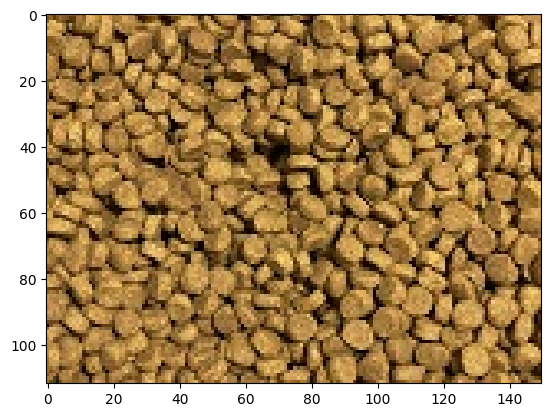

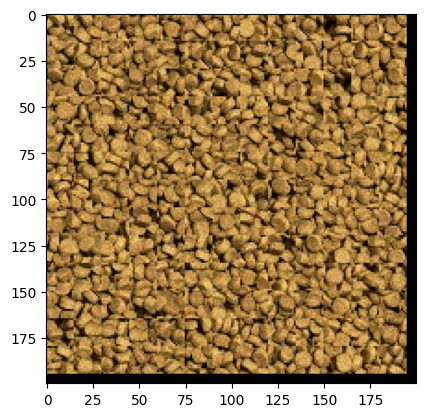

In [3]:
sample_img_fn = 'samples/catfood.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15 
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

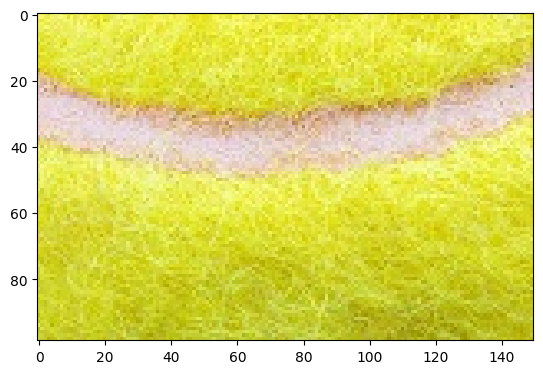

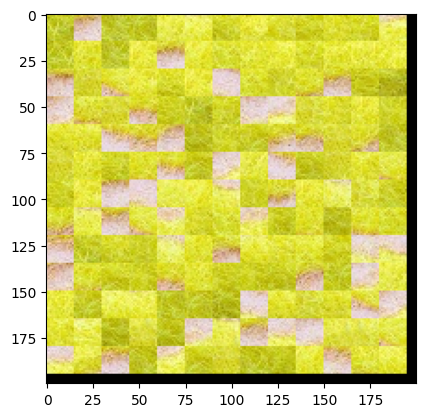

In [4]:
sample_img_fn = 'samples/tennis.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 200  # change these parameters as needed
patch_size = 15 
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [5]:
def ssd_patch(sample, template, mask):
    sample = sample.astype(np.float32) / 255.0
    template = template.astype(np.float32) / 255.0
    cost_matrix = np.zeros(sample.shape[:2])
    for channel in range(sample.shape[2]):
        I = sample[:, :, channel]
        T = template[:, :, channel]
        channel_cost = ((mask * T) ** 2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel=mask*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=mask)
        cost_matrix += channel_cost
        
    half_size = template.shape[0] // 2
    cost_matrix[:half_size, :] = np.inf
    cost_matrix[:, :half_size] = np.inf
    cost_matrix[-half_size:, :] = np.inf
    cost_matrix[:, -half_size:] = np.inf
    return cost_matrix

def choose_sample(cost_image, tol=1):
    height, width = cost_image.shape
    sorted_indices = np.argsort(cost_image.flatten())
    rand_index = np.random.randint(0, tol)
    selected_index = sorted_indices[rand_index]
    x = selected_index // width
    y = selected_index % width
    return x, y
    
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    half_size = patch_size // 2
    output = np.zeros((out_size, out_size, 3), dtype=sample.dtype)

    for i in range(0, out_size - patch_size, patch_size - overlap):
        for j in range(0, out_size - patch_size, patch_size - overlap):
            if i == 0 and j == 0:
                x, y = np.random.randint(0, sample.shape[0] - patch_size), np.random.randint(0, sample.shape[1] - patch_size)
                output[:patch_size, :patch_size] = sample[x:x+patch_size, y:y+patch_size]
                continue
                
            template = output[i:i+patch_size, j:j+patch_size]
            mask = np.zeros(template.shape[:2])
            if i != 0:
                mask[:overlap, :] = 1
            if j != 0:
                mask[:, :overlap] = 1

            cost = ssd_patch(sample, template, mask)
            x, y = choose_sample(cost, tol)

            patch = sample[x-half_size:x+half_size+1, y-half_size:y+half_size+1]
            output[i:i+patch_size, j:j+patch_size] = patch

    return output

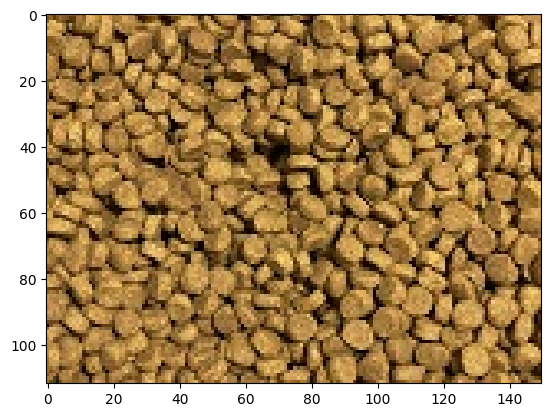

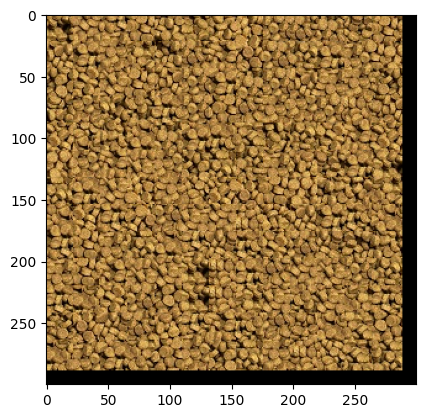

In [6]:
sample_img_fn = 'samples/catfood.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 3
tol = 20
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    # plt.figure(figsize=(10,10))
    plt.imshow(res)

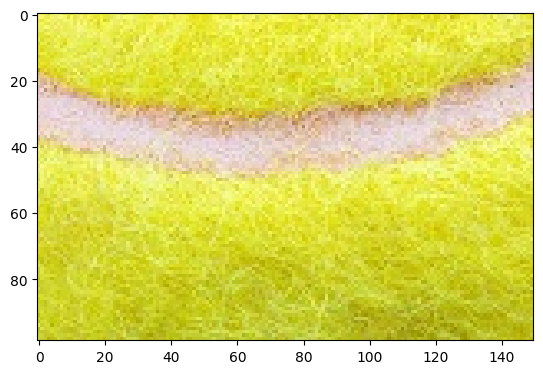

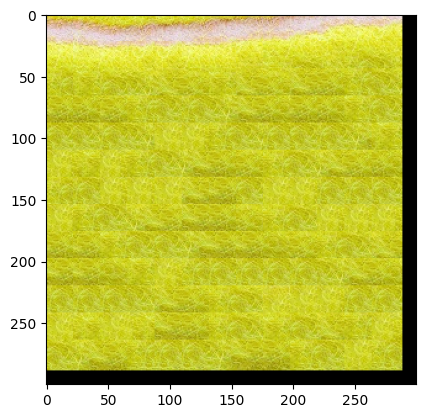

In [7]:
sample_img_fn = 'samples/tennis.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
overlap = 3
tol = 7
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    # plt.figure(figsize=(10,10))
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [8]:
# optional or use cut(err_patch) directly
def customized_cut(err_patch):
    """
    Compute the minimum path from the left to right side of the patch using Dijkstra's algorithm
    
    :param err_patch: numpy.ndarray    cost of cutting through each pixel
    :return: numpy.ndarray             a 0-1 mask that indicates which pixels should be on either side of the cut
    """
    h, w = err_patch.shape

    # initialize the cost matrix and the direction matrix
    cost = np.zeros((h, w))
    dir_matrix = np.zeros((h, w), dtype=np.int32)

    # fill in the first column of the cost matrix
    for i in range(1, h):
        cost[i, 0] = err_patch[i, 0]

    # compute the cost of each path from left to right
    for j in range(1, w):
        for i in range(h):
            if i == 0:
                # if we're at the top row, only consider the paths from the left and left-down pixels
                candidates = np.array([cost[i, j-1], cost[i+1, j-1]])
                directions = np.array([0, 1])
            elif i == h-1:
                # if we're at the bottom row, only consider the paths from the left and left-up pixels
                candidates = np.array([cost[i-1, j-1], cost[i, j-1]])
                directions = np.array([-1, 0])
            else:
                # otherwise, consider the paths from the left, left-up, and left-down pixels
                candidates = np.array([cost[i-1, j-1], cost[i, j-1], cost[i+1, j-1]])
                directions = np.array([-1, 0, 1])
            # compute the cost of each candidate path
            costs = candidates + err_patch[i, j]
            # choose the minimum cost and update the cost matrix and direction matrix
            min_cost_idx = np.argmin(costs)
            cost[i, j] = costs[min_cost_idx]
            dir_matrix[i, j] = directions[min_cost_idx]

    # find the minimum-cost path
    path = np.zeros(w, dtype=np.int32)
    path[-1] = np.argmin(cost[:, -1])
    for j in range(w-2, -1, -1):
        i = path[j+1]
        path[j] = i + dir_matrix[i, j+1]

    # create the mask based on the minimum-cost path
    mask = np.ones((h, w), dtype=np.int32)
    mask[path, np.arange(w)] = 0
    
    # zero each column up to it's first original zero
    zero_loc = mask.argmin(axis=0)
    for i in range(mask.shape[1]):
        mask[:zero_loc[i], i] = 0

    return mask

In [9]:
def cut_cost(patch1, patch2):
    diff = (patch1 - patch2) ** 2
    return np.sum(diff, axis=2)

def quilt_cut(sample, out_size, patch_size, overlap, tol, plot_iter=False):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    half_size = patch_size // 2
    output = np.zeros((out_size, out_size, 3), dtype=sample.dtype)
    
    for i in range(0, out_size - patch_size, patch_size - overlap):
        for j in range(0, out_size - patch_size, patch_size - overlap):
            if i == 0 and j == 0:
                x, y = np.random.randint(0, sample.shape[0] - patch_size), np.random.randint(0, sample.shape[1] - patch_size)
                output[:patch_size, :patch_size] = sample[x:x+patch_size, y:y+patch_size]
                continue
                
            template = output[i:i+patch_size, j:j+patch_size]
            overlap_mask = np.zeros(template.shape[:2])
            if i != 0:
                overlap_mask[:overlap, :] = 1
            if j != 0:
                overlap_mask[:, :overlap] = 1

            cost = ssd_patch(sample, template, overlap_mask)
            x, y = choose_sample(cost, tol)
            patch = sample[x-half_size:x+half_size+1, y-half_size:y+half_size+1]
            seam_mask = np.ones(template.shape[:2])
            if i != 0:
                horizontal_cut_cost = cut_cost(patch[:overlap, :], template[:overlap, :])
                horizontal_seam = customized_cut(horizontal_cut_cost)
                seam_mask[:overlap, :] = horizontal_seam
            if j != 0:
                vertical_cut_cost = cut_cost(patch[:, :overlap], template[:, :overlap])
                vertical_seam = customized_cut(vertical_cut_cost.T).T
                seam_mask[:, :overlap] = vertical_seam
                
            # plot a seleted block
            if i == plot_iter and j == plot_iter:
                plt.imshow(output)
                plt.show()
    
                plt.imshow(template)
                plt.show()
            
                plt.imshow(horizontal_cut_cost)
                plt.show()
                
                plt.imshow(horizontal_seam)
                plt.show()
                
                plt.imshow(vertical_cut_cost)
                plt.show()
                
                plt.imshow(vertical_seam)
                plt.show()
                
                plt.imshow(seam_mask)
                plt.show()
                
                plt.imshow((template * np.logical_not(seam_mask)[:, :, np.newaxis]) / 255.0)
                plt.show()
                
                plt.imshow(patch * seam_mask[:, :, np.newaxis] / 255.0)
                plt.show()
                
            seam_patch = np.zeros_like(template)
            seam_patch[seam_mask == 0] = template[seam_mask == 0]
            seam_patch[seam_mask == 1] = patch[seam_mask == 1]
            output[i:i+patch_size, j:j+patch_size] = seam_patch
            
            

    return output

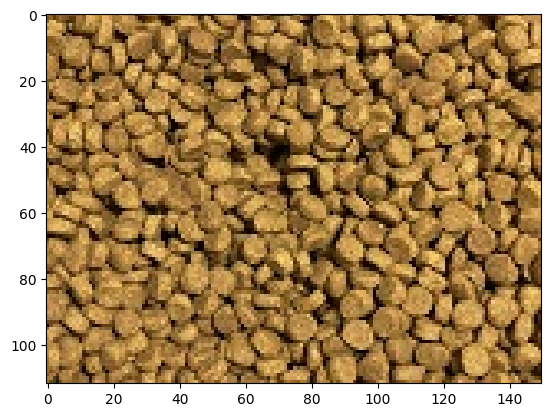

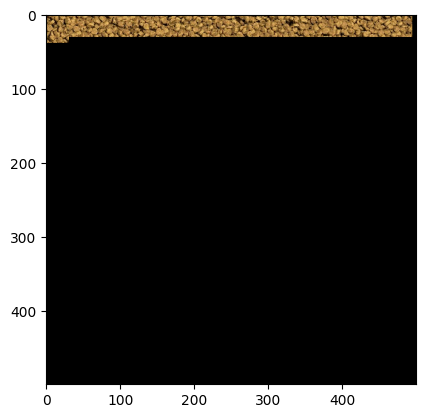

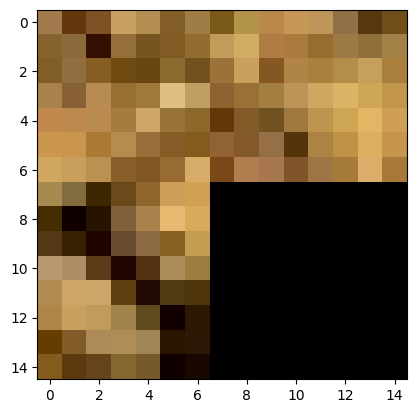

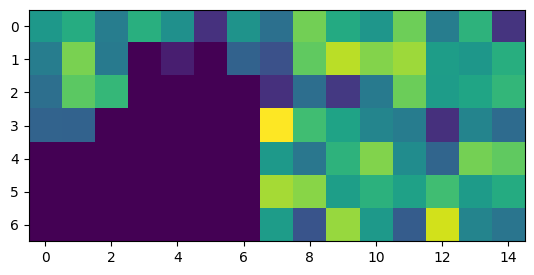

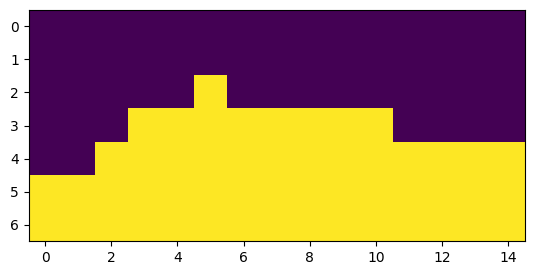

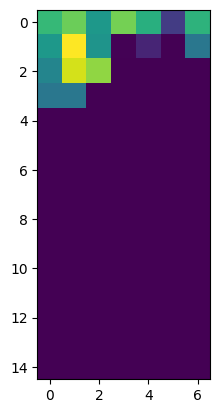

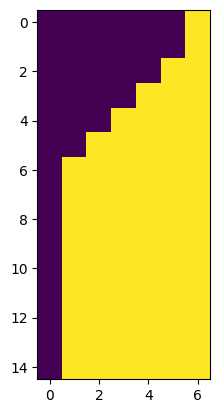

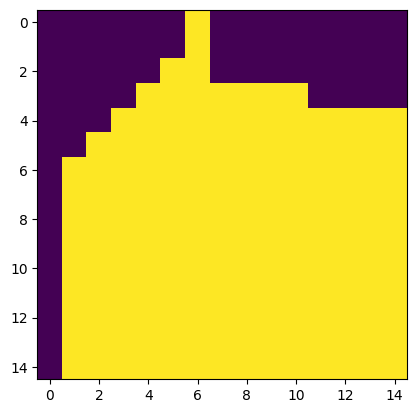

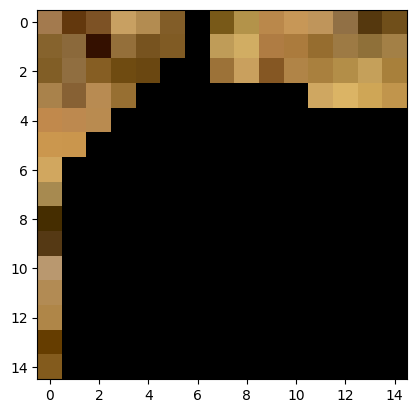

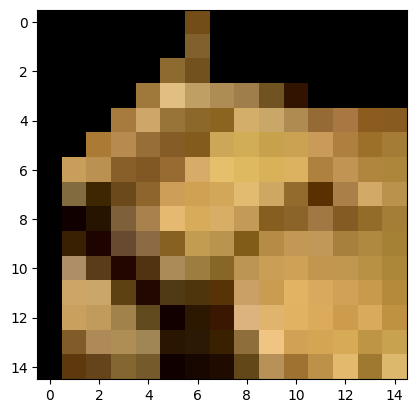

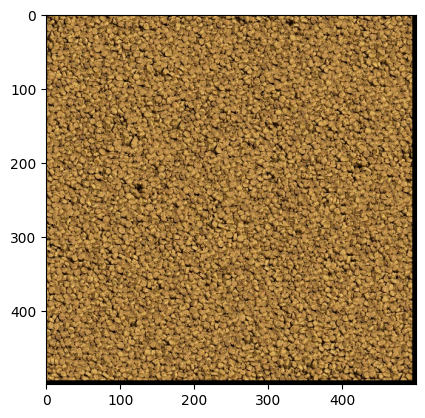

In [10]:
sample_img_fn = 'samples/catfood.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 500  # change these parameters as needed
patch_size = 15
overlap = 7
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol, plot_iter=(patch_size-overlap)*3)
if res is not None:
    # plt.figure(figsize=(15,15))
    plt.imshow(res)

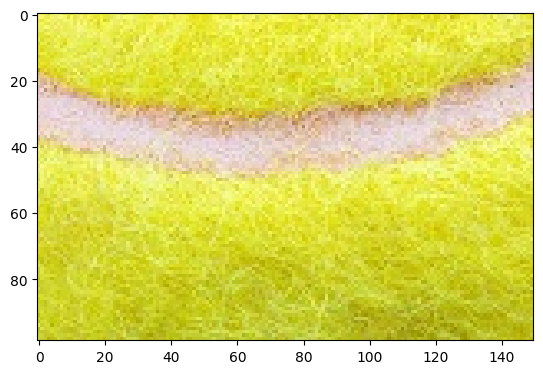

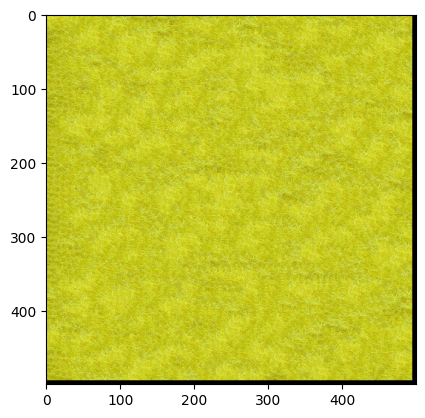

In [11]:
sample_img_fn = 'samples/tennis.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 500  # change these parameters as needed
patch_size = 15
overlap = 7
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    # plt.figure(figsize=(15,15))
    plt.imshow(res)

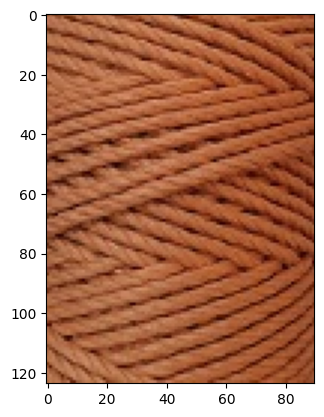

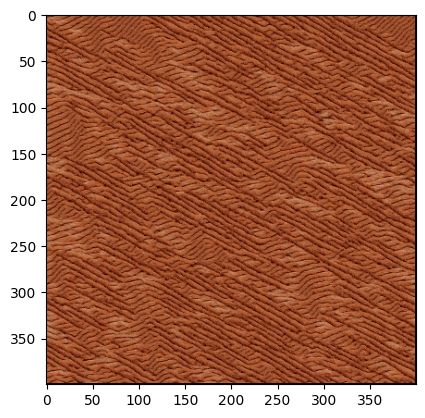

In [12]:
sample_img_fn = 'samples/thread.jpg' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 400  # change these parameters as needed
patch_size = 5
overlap = 3
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    # plt.figure(figsize=(15,15))
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [13]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    half_size = patch_size // 2
    output = np.zeros_like(guidance_im)

    for i in range(0, output.shape[0] - patch_size, patch_size - overlap):
        for j in range(0, output.shape[1] - patch_size, patch_size - overlap):
            if i == 0 and j == 0:
                x, y = np.random.randint(0, sample.shape[0] - patch_size), np.random.randint(0, sample.shape[1] - patch_size)
                output[:patch_size, :patch_size] = sample[x:x+patch_size, y:y+patch_size]
                continue
                
            template = output[i:i+patch_size, j:j+patch_size]
            overlap_mask = np.zeros(template.shape[:2])
            if i != 0:
                overlap_mask[:overlap, :] = 1
            if j != 0:
                overlap_mask[:, :overlap] = 1

            overlap_cost = ssd_patch(sample, template, overlap_mask)
            guidance_cost = ssd_patch(sample, guidance_im[i:i+patch_size, j:j+patch_size], np.ones(template.shape[:2]))
            combined_cost = alpha * overlap_cost.astype(np.float32) + (1 - alpha) * guidance_cost.astype(np.float32)
            x, y = choose_sample(combined_cost, tol)
            patch = sample[x-half_size:x+half_size+1, y-half_size:y+half_size+1]
            seam_mask = np.ones(template.shape[:2])
            if i != 0:
                seam_mask[:overlap, :] = customized_cut(cut_cost(patch[:overlap, :], template[:overlap, :]))
            if j != 0:
                seam_mask[:, :overlap] = customized_cut(cut_cost(patch[:, :overlap], template[:, :overlap]).T).T
                
            seam_patch = np.zeros_like(template)
            seam_patch[seam_mask == 0] = template[seam_mask == 0]
            seam_patch[seam_mask == 1] = patch[seam_mask == 1]
            output[i:i+patch_size, j:j+patch_size] = seam_patch

    return output

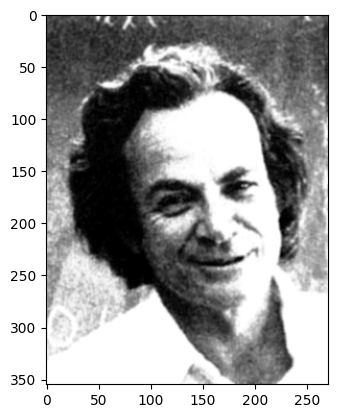

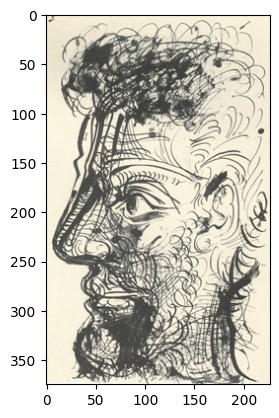

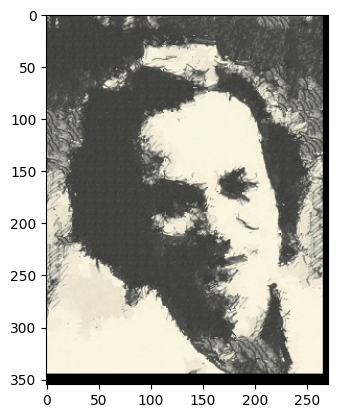

In [14]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/sketch.tiff' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/feynman.tiff' 
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()
plt.imshow(texture_img)
plt.show()

res = texture_transfer(texture_img, patch_size=15, overlap=5, tol=3,guidance_im=guidance_img, alpha=0.2)

# plt.figure(figsize=(15,15))
# plt.savefig('tennis_azouri.png', bbox_inches='tight')
plt.imshow(res)
plt.show()

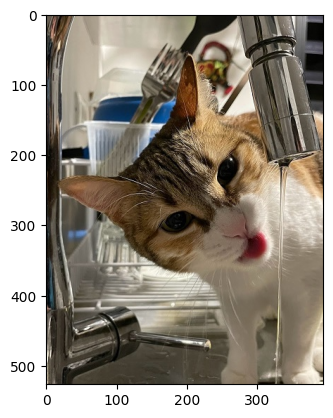

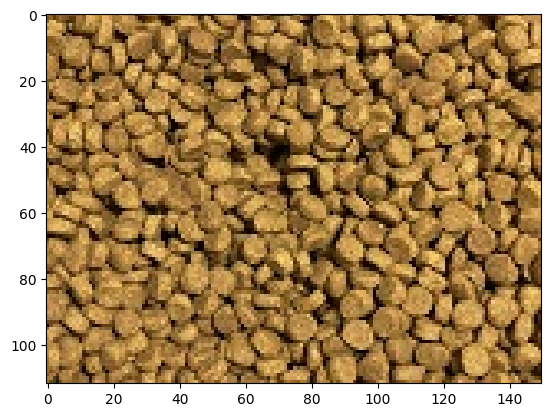

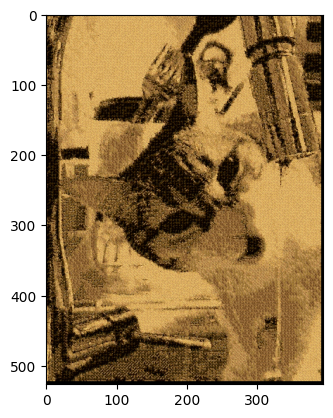

In [15]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/catfood.jpg' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/layla.jpg' 
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()
plt.imshow(texture_img)
plt.show()

res = texture_transfer(texture_img, patch_size=7, overlap=3, tol=3,guidance_im=guidance_img, alpha=0.1)

# plt.figure(figsize=(15,15))
# plt.savefig('tennis_azouri.png', bbox_inches='tight')
plt.imshow(res)
plt.show()

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

In [16]:
def customized_cut(err_patch):
    h, w = err_patch.shape

    # initialize the cost matrix and the direction matrix
    cost = np.zeros((h, w))
    dir_matrix = np.zeros((h, w), dtype=np.int32)

    # fill in the first column of the cost matrix
    for i in range(1, h):
        cost[i, 0] = err_patch[i, 0]

    # compute the cost of each path from left to right
    for j in range(1, w):
        for i in range(h):
            if i == 0:
                # if we're at the top row, only consider the paths from the left and left-down pixels
                candidates = np.array([cost[i, j-1], cost[i+1, j-1]])
                directions = np.array([0, 1])
            elif i == h-1:
                # if we're at the bottom row, only consider the paths from the left and left-up pixels
                candidates = np.array([cost[i-1, j-1], cost[i, j-1]])
                directions = np.array([-1, 0])
            else:
                # otherwise, consider the paths from the left, left-up, and left-down pixels
                candidates = np.array([cost[i-1, j-1], cost[i, j-1], cost[i+1, j-1]])
                directions = np.array([-1, 0, 1])
            # compute the cost of each candidate path
            costs = candidates + err_patch[i, j]
            # choose the minimum cost and update the cost matrix and direction matrix
            min_cost_idx = np.argmin(costs)
            cost[i, j] = costs[min_cost_idx]
            dir_matrix[i, j] = directions[min_cost_idx]

    # find the minimum-cost path
    path = np.zeros(w, dtype=np.int32)
    path[-1] = np.argmin(cost[:, -1])
    for j in range(w-2, -1, -1):
        i = path[j+1]
        path[j] = i + dir_matrix[i, j+1]

    # create the mask based on the minimum-cost path
    mask = np.ones((h, w), dtype=np.int32)
    mask[path, np.arange(w)] = 0
    
    # zero each column up to it's first original zero
    zero_loc = mask.argmin(axis=0)
    for i in range(mask.shape[1]):
        mask[:zero_loc[i], i] = 0

    return mask

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [18]:
def iterative_texture_transfer(sample, iterations, patch_sizes, overlaps, tol, guidance_im, alpha):
    output = np.zeros_like(guidance_im)
    
    for iteration in range(iterations):
        patch_size = patch_sizes[iteration]
        overlap = overlaps[iteration]
        half_size = patch_size // 2
        
        for i in range(0, output.shape[0] - patch_size, patch_size - overlap):
            for j in range(0, output.shape[1] - patch_size, patch_size - overlap):
                if iteration == 0 and i == 0 and j == 0:
                    x, y = np.random.randint(0, sample.shape[0] - patch_size), np.random.randint(0, sample.shape[1] - patch_size)
                    output[:patch_size, :patch_size] = sample[x:x+patch_size, y:y+patch_size]
                    continue

                template = output[i:i+patch_size, j:j+patch_size]
                if iteration == 0:
                    overlap_mask = np.ones(template.shape[:2])
                else:
                    overlap_mask = np.zeros(template.shape[:2])
                    if i != 0:
                        overlap_mask[:overlap, :] = 1
                    if j != 0:
                        overlap_mask[:, :overlap] = 1

                overlap_cost = ssd_patch(sample, template, overlap_mask)
                guidance_cost = ssd_patch(sample, guidance_im[i:i+patch_size, j:j+patch_size], np.ones(template.shape[:2]))
                combined_cost = alpha * overlap_cost.astype(np.float32) + (1 - alpha) * guidance_cost.astype(np.float32)
                x, y = choose_sample(combined_cost, tol)
                patch = sample[x-half_size:x+half_size+1, y-half_size:y+half_size+1]
                seam_mask = np.ones(template.shape[:2])
                if i != 0:
                    seam_mask[:overlap, :] = customized_cut(cut_cost(patch[:overlap, :], template[:overlap, :]))
                if j != 0:
                    seam_mask[:, :overlap] = customized_cut(cut_cost(patch[:, :overlap], template[:, :overlap]).T).T

                seam_patch = np.zeros_like(template)
                seam_patch[seam_mask == 0] = template[seam_mask == 0]
                seam_patch[seam_mask == 1] = patch[seam_mask == 1]
                output[i:i+patch_size, j:j+patch_size] = seam_patch
                
        plt.imshow(output)
        plt.show()
        
    return output

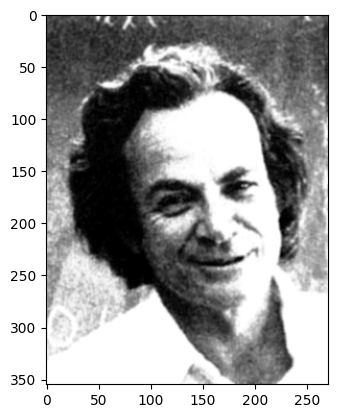

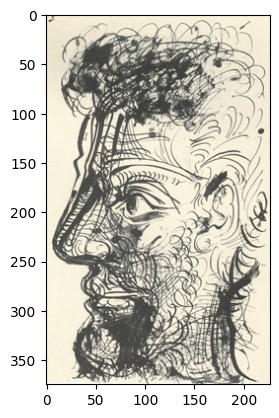

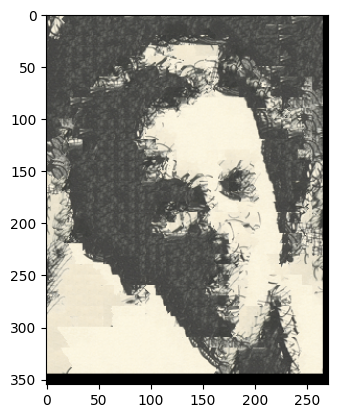

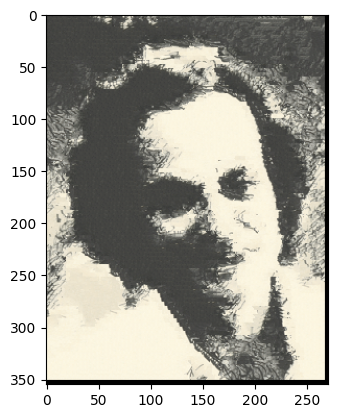

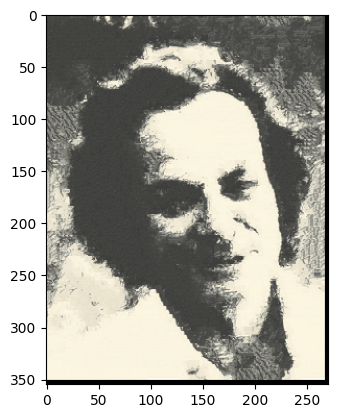

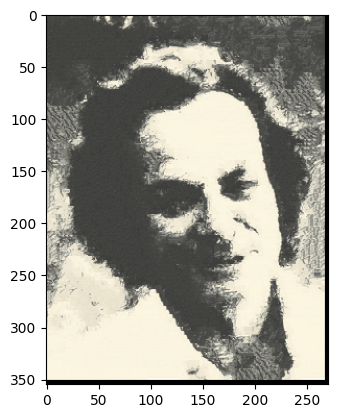

In [19]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/sketch.tiff' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/feynman.tiff' 
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()
plt.imshow(texture_img)
plt.show()

res = iterative_texture_transfer(texture_img, iterations=3, patch_sizes=[25, 15, 11], overlaps=[15, 11, 7], tol=3, guidance_im=guidance_img, alpha=0.2)

# plt.figure(figsize=(15,15))
# plt.savefig('tennis_azouri.png', bbox_inches='tight')
plt.imshow(res)
plt.show()

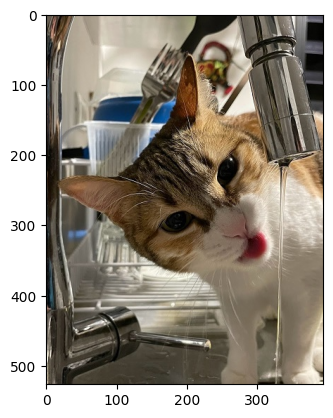

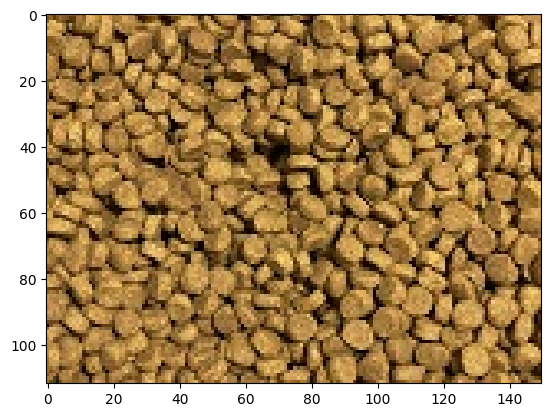

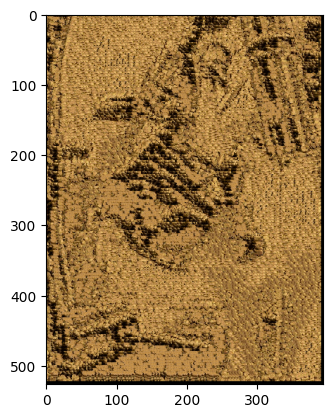

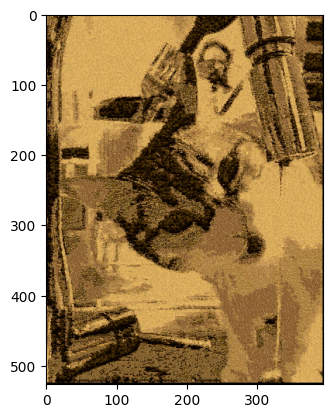

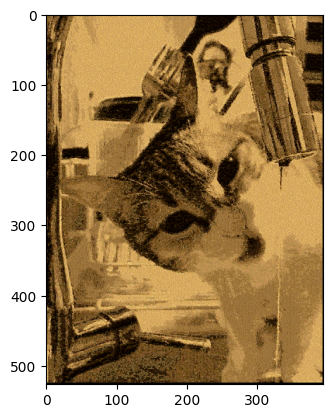

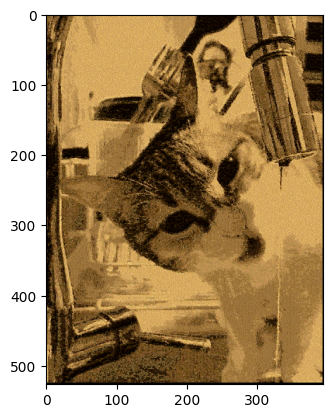

In [20]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/catfood.jpg' 
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img_fn = 'samples/layla.jpg' 
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_img)
plt.show()
plt.imshow(texture_img)
plt.show()

res = iterative_texture_transfer(texture_img, iterations=3, patch_sizes=[15, 7, 5], overlaps=[11, 5, 3], tol=3, guidance_im=guidance_img, alpha=0.2)

# plt.figure(figsize=(15,15))
# plt.savefig('tennis_azouri.png', bbox_inches='tight')
plt.imshow(res)
plt.show()

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

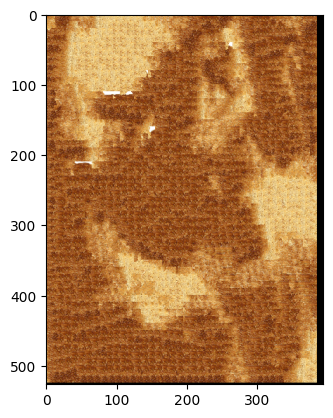

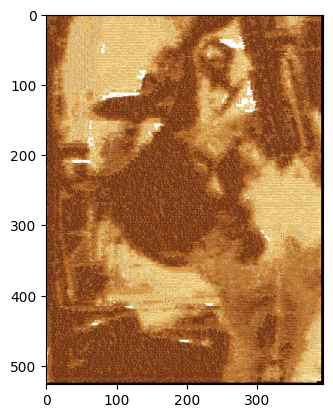

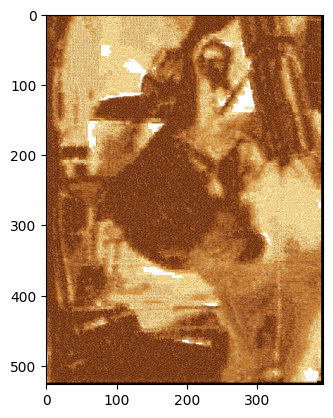

In [21]:
def gaussian_pyramid(img, num_levels):
    working_img = np.float32(img.copy())
    gaussian_pyr = [working_img]
    for i in range(num_levels):
        working_img = cv2.pyrDown(working_img)
        gaussian_pyr.append(np.float32(working_img))
    return gaussian_pyr

def laplacian_pyramid(gaussian_pyr):
    laplacian_top = gaussian_pyr[-1]
    num_levels = len(gaussian_pyr) - 1
    
    laplacian_pyr = [laplacian_top]
    for i in range(num_levels,0,-1):
        size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
        laplacian = np.subtract(gaussian_pyr[i-1], gaussian_expanded)
        laplacian_pyr.append(laplacian)
    return laplacian_pyr

def blend(laplacian_A,laplacian_B,mask_pyr):
    LS = []
    for la,lb,mask in zip(laplacian_A,laplacian_B,mask_pyr):
        ls = lb * mask + la * (1.0 - mask)
        LS.append(ls)
    return LS


def reconstruct(laplacian_pyr):
    laplacian_top = laplacian_pyr[0]
    laplacian_lst = [laplacian_top]
    num_levels = len(laplacian_pyr) - 1
    for i in range(num_levels):
        size = (laplacian_pyr[i + 1].shape[1], laplacian_pyr[i + 1].shape[0])
        laplacian_expanded = cv2.pyrUp(laplacian_top, dstsize=size)
        laplacian_top = cv2.add(laplacian_pyr[i+1], laplacian_expanded)
        laplacian_lst.append(laplacian_top)
    return laplacian_lst

# load the images
img1 = cv2.cvtColor(cv2.imread('samples/toast.jpg'), cv2.COLOR_BGR2RGB)
img1 = cv2.resize(img1, (100, 100))
img2 = iterative_texture_transfer(img1, iterations=3, patch_sizes=[25, 15, 11], overlaps=[15, 11, 7], tol=3, guidance_im=guidance_img, alpha=0.2)
img2 = cv2.resize(img2, (100, 100))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


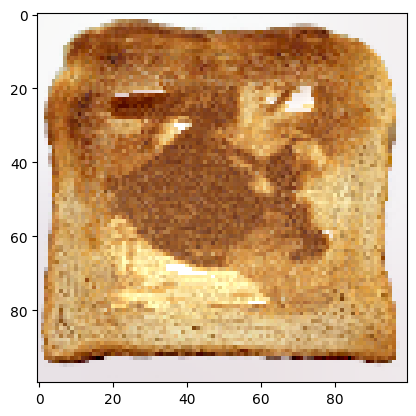

In [22]:
# create the mask
mask = np.zeros((100,100,3), dtype='float32')
mask[20:80,20:80,:] = (1,1,1)

num_levels = 6

# calculate Gaussian and Laplacian
gaussian_pyr_1 = gaussian_pyramid(img1, num_levels)
laplacian_pyr_1 = laplacian_pyramid(gaussian_pyr_1)
gaussian_pyr_2 = gaussian_pyramid(img2, num_levels)
laplacian_pyr_2 = laplacian_pyramid(gaussian_pyr_2)

# calculate the Gaussian pyramid for the mask and reverse it
mask_pyr_final = gaussian_pyramid(mask, num_levels)
mask_pyr_final.reverse()

# blend the images
add_laplace = blend(laplacian_pyr_1,laplacian_pyr_2,mask_pyr_final)
# reconstruct the images
final = reconstruct(add_laplace)
# Save the final image to the disk
plt.imshow(final[num_levels] / 255.0)
plt.show()